In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mapply
mapply.init(n_workers=7, progressbar=True)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean4.csv')

# final['isArrested'] = (final['n_arrested'] > 0)
# final['isInjured'] = (final['n_injured'] > 0)
# final['isUnharmed'] = (final['n_unharmed'] > 0)
# final = final[final['OUTLIER'] == 0]

final['isKilled'] = (final['n_killed'] > 0)
final['isInjured'] = (final['n_injured'] > 0)
final['isUnharmed'] = (final['n_unharmed'] > 0)
final['isArrested'] = (final['n_arrested'] > 0)

value_counts = final['isKilled'].value_counts()
min_vc = value_counts.min()
max_vc = value_counts.max()

def rebalance(df, size):
    if df.shape[0] < size:
        return df.sample(size, replace=True, random_state=0)
    else:
        return df.sample(size, random_state=0)

final['congressional_district'] = final['congressional_district'].astype(str)

#  Rebalance classes
## Upsample
final = final.groupby('isKilled').apply(lambda x: rebalance(x, max_vc)).reset_index(drop=True)



## Downsample
# final = final.groupby('isKilled').apply(lambda x: x.sample(min_vc)).reset_index(drop=True)


In [53]:
augmented = final.copy()

from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(augmented, test_size=0.2)
train, valid = train_test_split(train_valid, test_size=0.2)

train: pd.DataFrame = train
valid: pd.DataFrame = valid
test: pd.DataFrame = test

idx_train = train.index
idx_valid = valid.index
idx_test = test.index




train['state_year_p_isKilled'] = train.groupby(['state', 'date_year', 'date_month'])['isKilled'].transform('mean')
train['state_year_p_isArrested'] = train.groupby(['state', 'date_year', 'date_month'])['isArrested'].transform('mean')
train['state_year_p_isInjured'] = train.groupby(['state', 'date_year', 'date_month'])['isInjured'].transform('mean')
train['state_year_p_isUnharmed'] = train.groupby(['state', 'date_year', 'date_month'])['isUnharmed'].transform('mean')

# print([x for x in train[['state', 'date_year', 'state_year_p_isKilled']].drop_duplicates().values])

state_year_p_isKilled = {(x[0], x[1], x[2]): (x[3], x[4], x[5], x[6]) for x in train[['state', 'date_year', 'date_month', 'state_year_p_isKilled', 'state_year_p_isArrested', 'state_year_p_isInjured', 'state_year_p_isUnharmed']].drop_duplicates().values}
def state_year_p_isKilled_lookup(state, year, month, idx):
    try:
        return state_year_p_isKilled[(state, year, month)][idx]
    except:
        return 0.5

valid['state_year_p_isKilled'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 0), axis=1)
valid['state_year_p_isArrested'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 1), axis=1)
valid['state_year_p_isInjured'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 2), axis=1)
valid['state_year_p_isUnharmed'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 3), axis=1)

test['state_year_p_isKilled'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 0), axis=1)
test['state_year_p_isArrested'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 1), axis=1)
test['state_year_p_isInjured'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 2), axis=1)
test['state_year_p_isUnharmed'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 3), axis=1)

# augmented.loc[idx_train, 'state_year_p_isKilled'] = train['state_year_p_isKilled']
# augmented.loc[idx_train, 'state_year_p_isArrested'] = train['state_year_p_isArrested']
# augmented.loc[idx_train, 'state_year_p_isInjured'] = train['state_year_p_isInjured']
# augmented.loc[idx_train, 'state_year_p_isUnharmed'] = train['state_year_p_isUnharmed']
# augmented.loc[idx_valid, 'state_year_p_isKilled'] = valid['state_year_p_isKilled']
# augmented.loc[idx_valid, 'state_year_p_isArrested'] = valid['state_year_p_isArrested']
# augmented.loc[idx_valid, 'state_year_p_isInjured'] = valid['state_year_p_isInjured']
# augmented.loc[idx_valid, 'state_year_p_isUnharmed'] = valid['state_year_p_isUnharmed']
# augmented.loc[idx_test, 'state_year_p_isKilled'] = test['state_year_p_isKilled']
# augmented.loc[idx_test, 'state_year_p_isArrested'] = test['state_year_p_isArrested']
# augmented.loc[idx_test, 'state_year_p_isInjured'] = test['state_year_p_isInjured']
# augmented.loc[idx_test, 'state_year_p_isUnharmed'] = test['state_year_p_isUnharmed']

In [54]:
discretized = augmented.copy()

discretized['state_congressional_district'] = discretized['state'].astype(str) + '_' + discretized['congressional_district'].astype(str)

TO_DISCRETIZE = ['state', 'party']

cat_cols = discretized.select_dtypes(include=['object']).columns
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

def one_hot(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        vars = sorted(dataset[variable].unique())
        
        for var in vars:
            dataset[variable+'_'+str(var)] = (dataset[variable] == var).astype(int)
    return dataset

# discretized = one_hot(discretized, TO_DISCRETIZE)
discretized = discretize_data(discretized, cat_cols)
discretized = discretized.drop(columns=cat_cols)

discretized.shape

# final = final.drop(columns=cat_cols)

(349818, 85)

In [55]:
f = discretized.copy()

isKilled = f['isKilled']

del f['isKilled']
del f['isInjured']
del f['isUnharmed']
del f['isArrested']

keywords = ['n_', 'date', 'killed', 'arrested', 'injured', 'unharmed', '_males', 'n_participants', 'DEAD', 'CLEAN', 'OUTLIER', 'incident_', 'cd_', 'state_']
whitelist = ['participants_', 'n_injured', 'n_unharmed', 'n_arrested', 'state_year_p_']
blacklist = ['killed', 'adult']
# keywords = ['killed', 'DEAD', 'CLEAN', 'OUTLIER']
# whitelist = []
# blacklist = ['killed']
# del all columns with keywords in it
deleted = []
for col in f.columns:
    if any([b in col for b in blacklist]):
        deleted.append(col)
        del f[col]
    elif any([w in col for w in keywords]) and not any([w in col for w in whitelist]):
        deleted.append(col)
        del f[col]

print(deleted)

# f = f[['povertyPercentage', 'date_year']]


f = f.astype('float64')


# del f['n_killed']
# del f['p_killed']
# del f['month_cd_ratio_killed']


['date_year', 'date_month', 'date_day', 'min_age_participants', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_participants', 'CLEAN', 'candidatevotes', 'state_population', 'OUTLIER', 'p_males', 'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed', 'month_cd_change_min_age_participants', 'month_cd_change_avg_age_participants', 'month_cd_change_max_age_participants', 'year_state_change_min_age_participants', 'year_state_change_avg_age_participants', 'year_state_change_max_age_participants', 'month_cd_ratio_males', 'month_cd_ratio_females', 'month_cd_ratio_participants_adult', 'month_cd_ratio_killed', 'month_cd_ratio_injured', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed', 'year_state_ratio_males', 'year_state_ratio_females', 'year_state_ratio_participants_adult', 'year_state_ratio_killed', 'year_state_ratio_injured', 'year_state_ratio_arrested', 'year_state_ratio_unharmed', 'month_cd_incidents', 'month_cd_votes_incidents', 'year_state_incide

In [58]:
f.columns

Index(['latitude', 'longitude', 'avg_age_participants', 'max_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_injured',
       'n_arrested', 'n_unharmed', 'timestamp', 'povertyPercentage',
       'totalvotes', 'p_females', 'p_participants_child',
       'p_participants_teen', 'month_cd_ratio_participants_child',
       'month_cd_ratio_participants_teen',
       'year_state_ratio_participants_child',
       'year_state_ratio_participants_teen', 'percentage_republican',
       'percentage_democrat', 'congressional_district_num',
       'city_or_county_num', 'party_num'],
      dtype='object')

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the data
scaled = scaler.fit_transform(f)

# Convert to a dataframe
scaled = pd.DataFrame(scaled, columns=f.columns)


scaled = f

In [61]:
X_train = scaled.loc[idx_train]
X_valid = scaled.loc[idx_valid]
X_test = scaled.loc[idx_test]


y_train = isKilled.loc[idx_train]
y_valid = isKilled.loc[idx_valid]
y_test = isKilled.loc[idx_test]

In [47]:
from sklearn.tree import ExtraTreeClassifier

clf = ExtraTreeClassifier(splitter='best', random_state=0, max_depth=5, min_samples_leaf=10)
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_valid)
print(accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

# export features
importance = clf.feature_importances_

importance = pd.DataFrame(importance, index=X_train.columns)

importance.sort_values(by=0, ascending=False)

from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(clf, out_file=None,
                            feature_names=X_train.columns,
                            class_names=['Not Killed', 'Killed'],
                            filled=True, rounded=True,
                            special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('etree.png')

0.7279126690607636
              precision    recall  f1-score   support

       False       0.75      0.69      0.72     27881
        True       0.71      0.77      0.74     28090

    accuracy                           0.73     55971
   macro avg       0.73      0.73      0.73     55971
weighted avg       0.73      0.73      0.73     55971



True

/tmp/ipykernel_7257/2108427335.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weight = {0: train_vc[1] / train_vc[0], 1: 1}


0.926211458663677
0.8871558485644352
[[105203   6739]
 [  9781 102160]]
[[24980  3045]
 [ 3271 24675]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     28025
           1       0.89      0.88      0.89     27946

    accuracy                           0.89     55971
   macro avg       0.89      0.89      0.89     55971
weighted avg       0.89      0.89      0.89     55971



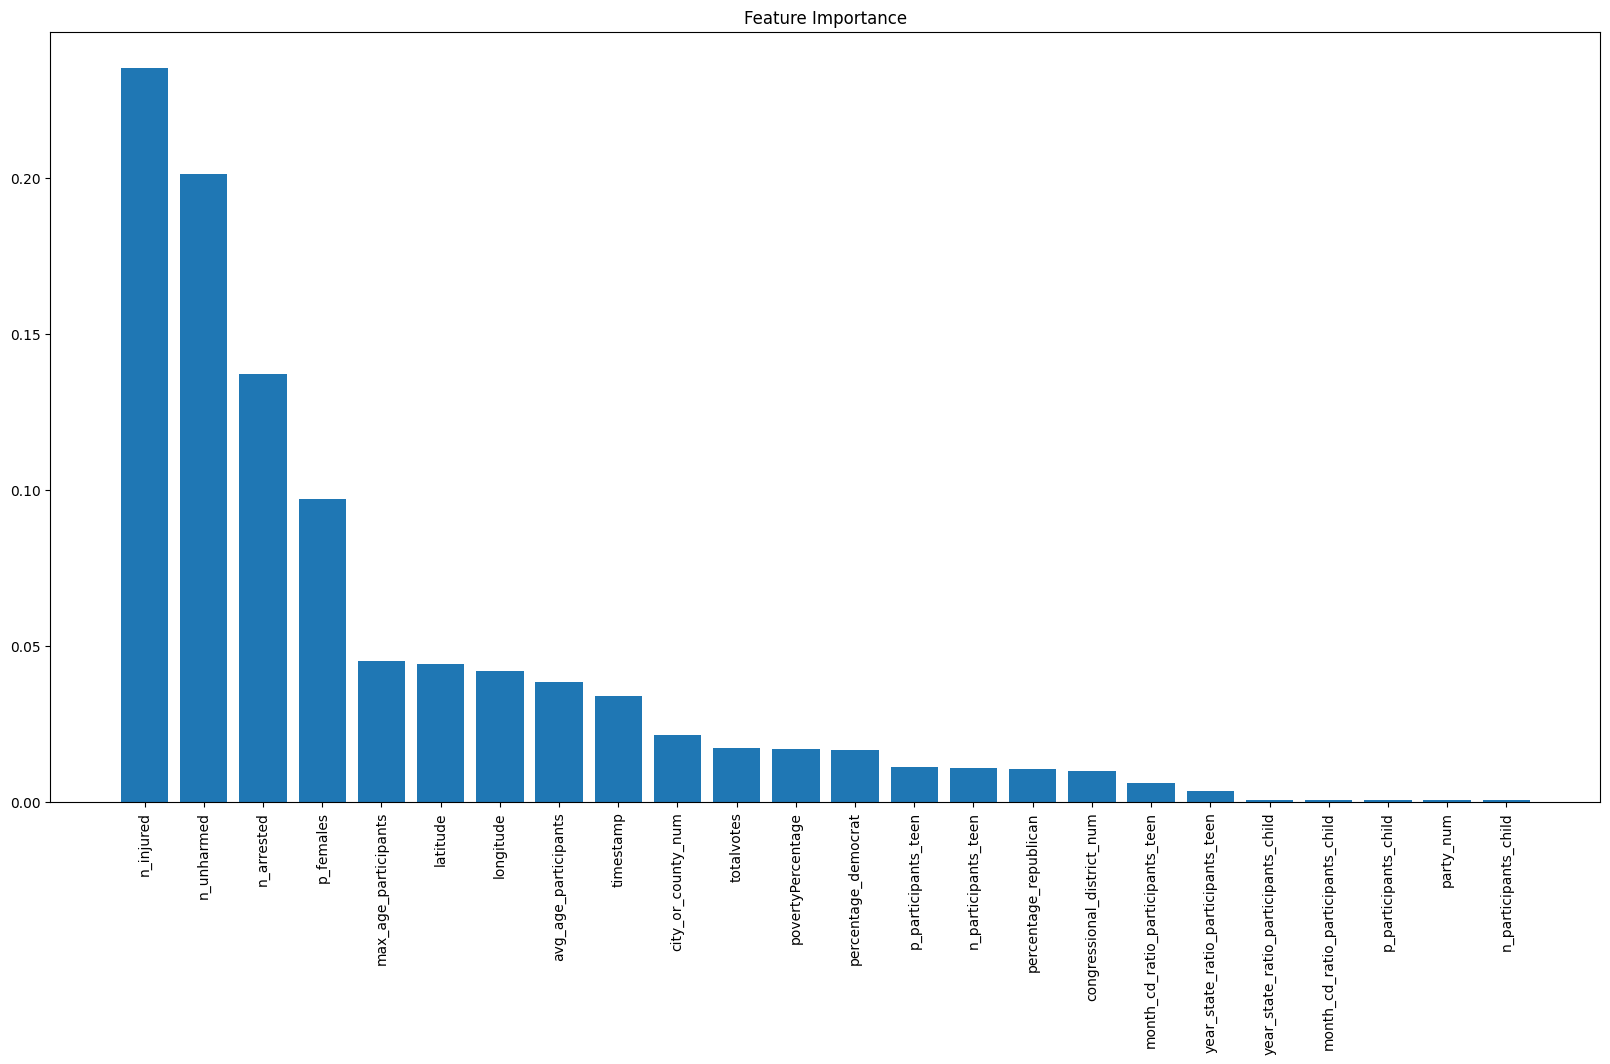

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

train_vc = y_train.value_counts()
class_weight = {0: train_vc[1] / train_vc[0], 1: 1}

clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, min_samples_split=3, min_samples_leaf=4, class_weight=class_weight)

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_valid)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_valid, y_pred))
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_valid, y_pred, labels=[0, 1]))

from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred, labels=[0, 1]))

from matplotlib import pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()


In [70]:
from sklearn.tree import export_graphviz

import pydotplus

# from IPython.display import Image
dot_data = export_graphviz(clf, out_file=None, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], filled=True, rounded=True, special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('graph.png')

True

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20, min_samples_split=3, min_samples_leaf=4, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_valid)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_valid, y_pred))

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_valid, y_pred, labels=[0, 1]))


0.9410718991616157
0.897768487252327
[[108725   3217]
 [  9976 101965]]
[[26199  1826]
 [ 3896 24050]]


In [66]:
a = clf.feature_importances_
b = X_train.columns
c = pd.DataFrame(a, index=b)
c.sort_values(by=0, ascending=False)

,0
n_injured,0.306778
n_arrested,0.114403
n_unharmed,0.110054
longitude,0.052671
latitude,0.051845
p_females,0.044786
timestamp,0.042386
max_age_participants,0.041992
avg_age_participants,0.037308
city_or_county_num,0.030999


In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     28025
           1       0.93      0.86      0.89     27946

    accuracy                           0.90     55971
   macro avg       0.90      0.90      0.90     55971
weighted avg       0.90      0.90      0.90     55971



Epoch 1/50000, Loss: 0.2587, Accuracy: 0.5002, valid Accuracy: 0.4981
Epoch 101/50000, Loss: 0.2500, Accuracy: 0.5002, valid Accuracy: 0.4981
Epoch 201/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 301/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 401/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 501/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 601/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 701/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
Epoch 801/50000, Loss: 0.2500, Accuracy: 0.5001, valid Accuracy: 0.4981
[[27880     1]
 [28088     2]]
0.4981508281074128


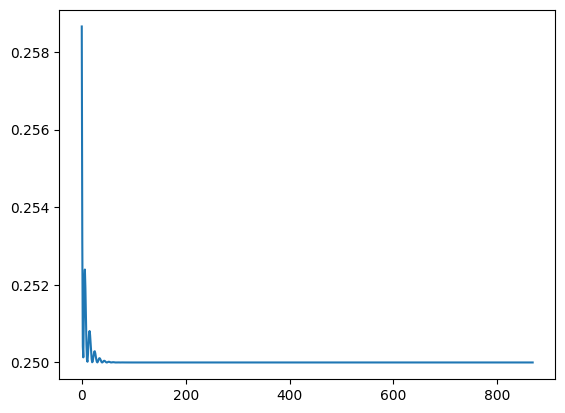

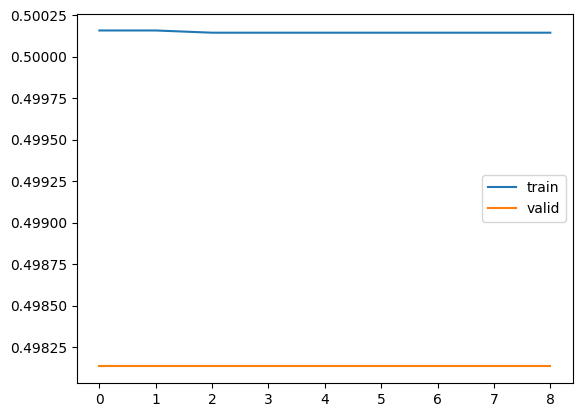

In [51]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).to(DEVICE)

input_size = X_train_tensor.shape[1]
hidden_size = 10
output_size = 1

loss_function = nn.MSELoss()

learning_rate = 0.01

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, 2),
    nn.Softmax(dim=output_size),
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

EPOCHS = 50000
losses = []
epochs = []
accs = []
accs_valid = []

model.train()
for epoch in range(EPOCHS):
    try:
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)[:, 1]
        loss = loss_function(y_pred, y_train_tensor)
        losses.append(loss.item())
        if epoch % 100 == 0:
            acc = accuracy_score(y_train_tensor.detach().cpu().numpy(), np.where(y_pred.detach().cpu() > 0.5, 1, 0))
            accs.append(acc)
            y_pred_valid = model(X_valid_tensor)
            y_pred_valid = y_pred_valid.squeeze(1)[:, 1].unsqueeze(1)
            acc_valid = accuracy_score(y_valid_tensor.detach().cpu().numpy(), np.where(y_pred_valid.detach().cpu() > 0.5, 1, 0))
            accs_valid.append(acc_valid)
            print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}, valid Accuracy: {acc_valid:.4f}')
        loss.backward()
        optimizer.step()
    except KeyboardInterrupt:
        break

from sklearn.metrics import confusion_matrix

# Convert the valid data to PyTorch tensors and get the predicted class
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_pred_tensor = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu()

y_pred = np.where(y_pred_tensor > 0.5, 1, 0)

# _, y_pred = torch.max(y_pred_tensor, 1)

# # Print the confusion matrix
print(confusion_matrix(y_valid, y_pred))

# # Print the accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))

# plot the loss over the entire training procedure
plt.plot(losses)
plt.show()

plt.plot(accs, label='train')
plt.plot(accs_valid, label='valid')
plt.legend()
plt.show()


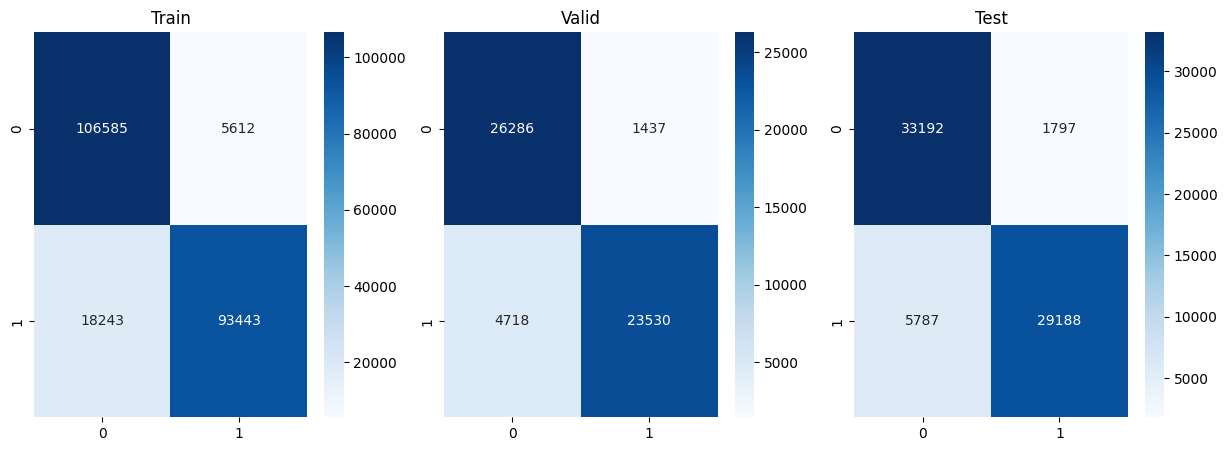

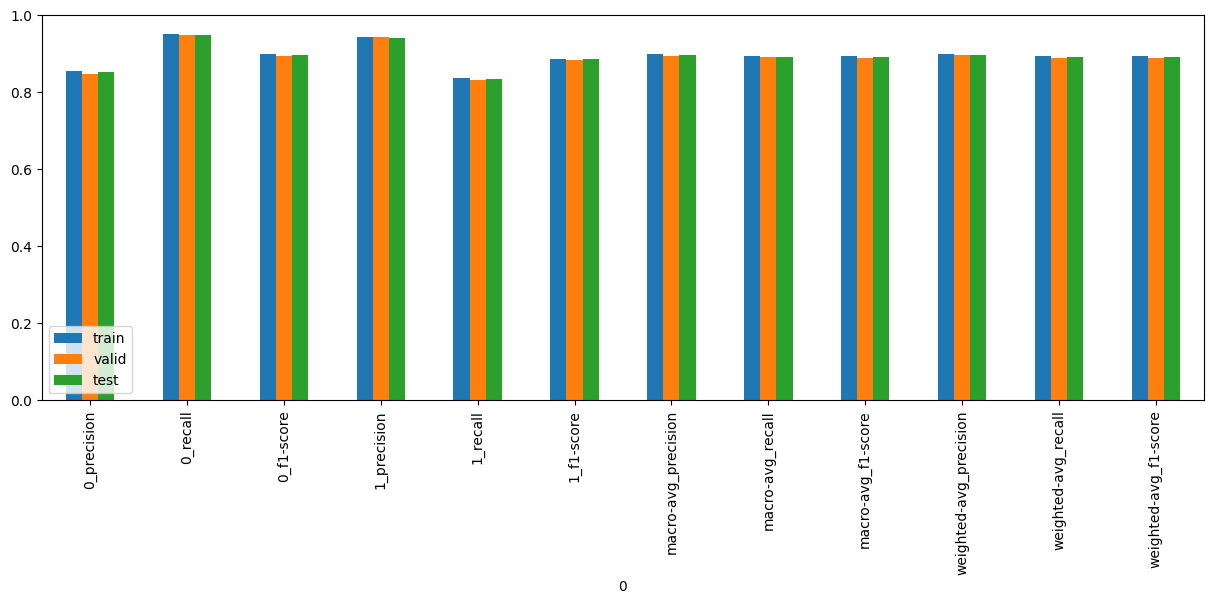

In [9]:
import seaborn as sns

def writable(class_report, base_key = '', separator = '_'):
    for key, value in class_report.items():
        if isinstance(value, dict):
            yield from writable(value, key)
        else:
            yield str(base_key + separator + key).replace(' ', '-'), value

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)

y_pred_train = np.where(model(X_train_tensor).detach().cpu() > .5, 1, 0)
y_pred_valid = np.where(model(X_valid_tensor).detach().cpu() > .5, 1, 0)
y_pred_test  = np.where(model(X_test_tensor).detach().cpu()  > .5, 1, 0)

# Confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('Train')
axs[1].set_title('Valid')
axs[2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', ax=axs[0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[2], cmap = 'Blues')
plt.show()

from sklearn.metrics import classification_report
# Scores
fig, ax = plt.subplots(figsize=(15, 5))
tr_cr = pd.DataFrame(writable(classification_report(y_train, y_pred_train, labels=[0, 1], output_dict=True), 'train'), columns=['0', 'train'])
tr_cr.set_index('0', inplace=True)
va_cr = pd.DataFrame(writable(classification_report(y_valid, y_pred_valid, labels=[0, 1], output_dict=True), 'valid'), columns=['0', 'valid'])
va_cr.set_index('0', inplace=True)
te_cr = pd.DataFrame(writable(classification_report(y_test, y_pred_test, labels=[0, 1], output_dict=True), 'test'), columns=['0', 'test'])
te_cr.set_index('0', inplace=True)

trvate = tr_cr.merge(va_cr, left_index=True, right_index=True)
trvate = trvate.merge(te_cr, left_index=True, right_index=True)

# remove all rows where index contains 'support'
trvate = trvate[~trvate.index.str.contains('support')]

trvate.plot.bar(ax=ax)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

In [10]:
from lime.lime_tabular import LimeTabularExplainer


def descale(x):
    return scaler.inverse_transform(x)

def scale(x):
    return scaler.transform(x)

explainer = LimeTabularExplainer(X_train.values, training_labels=y_train, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], discretize_continuous=True, discretizer='entropy', verbose=True)


# exp

In [11]:
def predict_fn(x):
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    c = model(x).detach().cpu().numpy()
    c = np.hstack([1 - c, c])
    return c


# exp = explainer.explain_instance(X_test.iloc[992], predict_fn, num_features=15)
exp = explainer.explain_instance(X_test.iloc[991], predict_fn, num_features=10)
# exp.save_to_file('exp.html')
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_list()




Intercept 0.7877853699529853
Prediction_local [0.27803791]
Right: 0.011498014
[('p_participants_child <= 0.08', 0.36505774115805745), ('n_participants_child <= 2.42', -0.352790543367363), ('n_females <= 0.48', -0.33144544681344396), ('n_participants_teen <= 0.74', -0.30859041002130816), ('p_participants_teen <= -0.19', 0.25923674546236797), ('0.08 < n_injured <= 1.39', -0.2576088569400491), ('n_arrested <= 0.08', 0.22998395258553114), ('0.11 < n_unharmed <= 1.29', -0.21025726415052617), ('p_females <= -0.10', 0.1859353757703532), ('party_DEMOCRAT > -0.14', -0.08926875804947673)]


/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

[('p_participants_child <= 0.08', 0.36505774115805745), ('n_participants_child <= 2.42', -0.352790543367363), ('n_females <= 0.48', -0.33144544681344396), ('n_participants_teen <= 0.74', -0.30859041002130816), ('p_participants_teen <= -0.19', 0.25923674546236797), ('0.08 < n_injured <= 1.39', -0.2576088569400491), ('n_arrested <= 0.08', 0.22998395258553114), ('0.11 < n_unharmed <= 1.29', -0.21025726415052617), ('p_females <= -0.10', 0.1859353757703532), ('party_DEMOCRAT > -0.14', -0.08926875804947673)]


[('p_participants_child <= 0.08', 0.36505774115805745),
 ('n_participants_child <= 2.42', -0.352790543367363),
 ('n_females <= 0.48', -0.33144544681344396),
 ('n_participants_teen <= 0.74', -0.30859041002130816),
 ('p_participants_teen <= -0.19', 0.25923674546236797),
 ('0.08 < n_injured <= 1.39', -0.2576088569400491),
 ('n_arrested <= 0.08', 0.22998395258553114),
 ('0.11 < n_unharmed <= 1.29', -0.21025726415052617),
 ('p_females <= -0.10', 0.1859353757703532),
 ('party_DEMOCRAT > -0.14', -0.08926875804947673)]

In [ ]:
import shap

X_test_sample = X_test.sample(10)
X_test_sample_tensor = torch.tensor(X_test_sample.values, dtype=torch.float32).to(DEVICE)

e = shap.DeepExplainer(model, X_train_tensor)
shap_values = e.shap_values(X_test_sample_tensor)

shap.summary_plot(shap_values, X_test_tensor, feature_names=X_test.columns, plot_type="bar")